# Portfolio Optimization

## Extract Historical Performance

In [65]:
# Import packages
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sci_opt

### Select securities and check for amount of history available

In [66]:
# List of securities
securities = ['TECB', 'SCHE', 'SCHF', 'SCHV', 'SCHG', 'KOMP', 'MDYG', 'MDYV', 'SLYG', 'SLYV', 'OSMAX', 'USMV', 'SBSPX', 'VOO', '^GSPC']

# Init Dataframe
df_min_date = pd.DataFrame(columns=['Min Date'])

# Capture the closing price for each security and add to dataframe
for security in securities:
    min_date = min(yf.Ticker(security).history(period='max').index)
    min_date_df = pd.DataFrame([min_date], columns=['Min Date'])
    df_min_date = pd.concat([df_min_date, min_date_df], ignore_index=True)

df_min_date.index = securities  # Assign securities as index after appending all rows

# Calculate the date 10 years ago from today, making it timezone-aware to match the DataFrame's timezone
ten_years_ago = pd.Timestamp(datetime.now() - timedelta(days=365*10)).tz_localize('America/New_York')

# Add a new column to indicate if the 'Min Date' is over 10 years from today
df_min_date['Over 10 Years'] = df_min_date['Min Date'] < ten_years_ago

df_min_date

C:\Users\sean1\AppData\Local\Temp\ipykernel_21812\834341146.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_min_date = pd.concat([df_min_date, min_date_df], ignore_index=True)


,Min Date,Over 10 Years
TECB,2020-01-13 00:00:00-05:00,False
SCHE,2010-01-14 00:00:00-05:00,True
SCHF,2009-11-03 00:00:00-05:00,True
SCHV,2009-12-15 00:00:00-05:00,True
SCHG,2010-01-04 00:00:00-05:00,True
KOMP,2018-10-23 00:00:00-04:00,False
MDYG,2005-11-15 00:00:00-05:00,True
MDYV,2005-11-15 00:00:00-05:00,True
SLYG,2000-10-02 00:00:00-04:00,True
SLYV,2000-10-02 00:00:00-04:00,True


### Pull from Yahoo Finance package historical data

In [67]:
# Init Dataframe
df = pd.DataFrame()

# Capture the closing price for each security and add to dataframe
for security in securities:
    if df_min_date.loc[security, 'Over 10 Years']:
        df[security] = yf.Ticker(security).history(start='2014-01-01', end=datetime.now().date().strftime("%Y-%m-%d")).Close
    


### EDA

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2571 entries, 2014-01-02 00:00:00-05:00 to 2024-03-20 00:00:00-04:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SCHE    2571 non-null   float64
 1   SCHF    2571 non-null   float64
 2   SCHV    2571 non-null   float64
 3   SCHG    2571 non-null   float64
 4   MDYG    2571 non-null   float64
 5   MDYV    2571 non-null   float64
 6   SLYG    2571 non-null   float64
 7   SLYV    2571 non-null   float64
 8   OSMAX   2571 non-null   float64
 9   USMV    2571 non-null   float64
 10  SBSPX   2571 non-null   float64
 11  VOO     2571 non-null   float64
 12  ^GSPC   2571 non-null   float64
dtypes: float64(13)
memory usage: 281.2 KB


In [69]:
df.head()

,SCHE,SCHF,SCHV,SCHG,MDYG,MDYV,SLYG,SLYV,OSMAX,USMV,SBSPX,VOO,^GSPC
Date,,,,,,,,,,,,,
2014-01-02 00:00:00-05:00,18.038139,23.579515,30.855175,20.588078,31.882490,30.555965,35.346096,37.864620,21.830843,29.024483,12.422214,140.151840,1831.979980
2014-01-03 00:00:00-05:00,18.015398,23.579515,30.901070,20.551382,32.081688,30.743744,35.514275,38.037209,21.959061,29.016224,12.415477,140.026443,1831.369995
2014-01-06 00:00:00-05:00,17.856163,23.556669,30.847528,20.459660,31.798788,30.649864,35.159882,37.641701,21.986055,28.950172,12.381793,139.675247,1826.770020
2014-01-07 00:00:00-05:00,17.931988,23.655678,30.992821,20.629354,31.986429,30.857189,35.522282,38.030010,22.019798,29.115316,12.455899,140.544846,1837.880005
2014-01-08 00:00:00-05:00,17.878914,23.625214,30.931648,20.656874,32.006638,30.919777,35.460220,37.850235,22.033295,29.107061,12.462632,140.603348,1837.489990


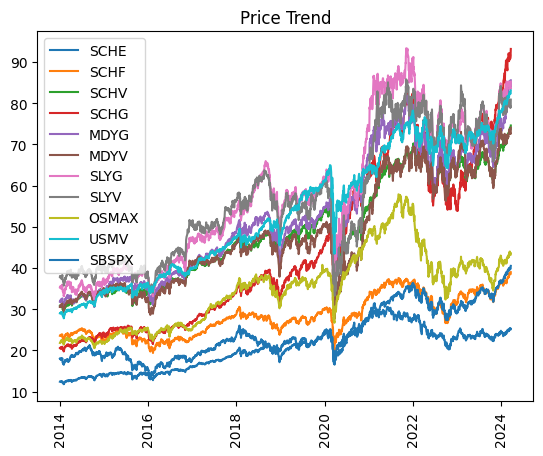

In [70]:
# Plot the close prices
plt.figure()
plt.plot(df.iloc[:,:-2]) # Excluded S&P 500 because of scale
plt.title('Price Trend')
plt.legend(df.columns)
plt.xticks(rotation=90)
plt.show()

### Correlations

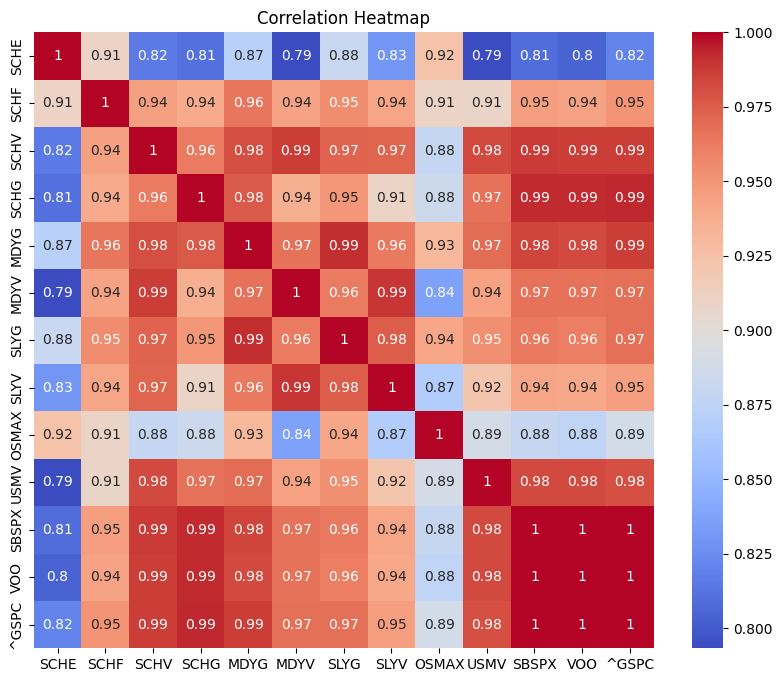

In [71]:
# Measure the correlation
import seaborn as sns

# Create a correlation matrix
corr_matrix = df.corr()

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap using the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Set the title of the plot
plt.title('Correlation Heatmap')

# Show the plot
plt.show()



In [72]:
df.describe()

,SCHE,SCHF,SCHV,SCHG,MDYG,MDYV,SLYG,SLYV,OSMAX,USMV,SBSPX,VOO,^GSPC
count,2571.000000,2571.000000,2571.000000,2571.000000,2571.000000,2571.000000,2571.000000,2571.000000,2571.000000,2571.000000,2571.000000,2571.000000,2571.000000
mean,21.999991,28.222311,48.520782,44.492655,52.117956,47.860992,57.699085,56.837925,34.847110,53.214376,22.486785,260.751366,3047.820560
std,3.626893,4.794313,12.412488,19.719676,14.697639,12.828335,16.814347,14.964101,9.184488,15.385158,7.712625,93.050896,935.939738
min,13.685317,19.393904,29.172863,19.767122,30.511230,27.713686,32.416283,33.298435,20.555408,27.810658,11.815926,133.446472,1741.890015
25%,19.278355,24.036992,36.526451,25.732061,37.793459,35.967081,40.735949,41.796108,25.364302,38.776129,15.034079,171.403412,2130.359985
50%,22.143070,27.710037,46.705669,38.157917,50.302849,45.002060,56.442207,54.817562,35.855328,51.581772,20.522160,236.740356,2815.620117
75%,23.979280,32.324818,62.062906,62.012039,66.593712,62.344696,72.440922,72.089344,40.527548,69.154930,30.156091,354.141373,3953.285034
max,31.504097,39.000000,74.589996,93.160004,85.550003,74.070000,93.331566,85.786003,57.892086,83.099998,40.529999,479.750000,5224.620117


## Calculate Sharpe Ratios

### Define Function will produce the pct change for the daily prices for each period

In [73]:
def period_pct_change(df, period=1):
    """
    This function filters the dataframe for the specified periods and return a dataframe with the pct_change applied to the daily price movements. 
    
    Parameters:
    - Period (int): Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. 
    
    Returns:
    Dataframe with the pct change of the price for the specified period.
    """    
    # Get today's date
    today = pd.Timestamp(datetime.now()).tz_localize('America/New_York')
    
    # Calculate the start_date and end_date
    start_date = today.replace(year=today.year - period, month=1, day=1)
    end_date = today.replace(year=today.year - 1, month=12, day=31)
    
    # Filters for records between the start_date and end_date.
    pct_change_df = df.loc[start_date:end_date].pct_change()
    
    return pct_change_df

### Define Function to extract 1, 5, and 10 years performance

In [74]:
def calculate_metrics(period=1):
    """
    This function calculates the annualzed returns, volatility and sharpe ratios between the start and end dates.
    
    Parameters:
    - Period : Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. 
    
    Returns:
    Dataframe with annualized return, volatility and sharpe ration for each security as a row
    """
    
    # Calculate Daily Simple returns
    daily_simple_returns = period_pct_change(df, period=period)

    # Calcuate the annualized returns
    annualized_returns = daily_simple_returns.mean() * 252 # 252 is the average number of trading days in a year

    # Calculate the Standard Deviation
    risk_std = daily_simple_returns.std() * np.sqrt(252)

    # Calculate the Sharpe Ratio
    sharpe_ratio = annualized_returns / risk_std

    # Combine the results
    simulations_data = [annualized_returns, risk_std, sharpe_ratio]

    # Create a DataFrame from it, then Transpose it so it looks like our original one.
    simulations_df = pd.DataFrame(data=simulations_data).T

    # Give the columns the Proper Names.
    simulations_df.columns = [item + "_" + str(period) for item in ['Returns', 'Volatility', 'Sharpe Ratio']]

    # Make sure the data types are correct, we don't want our floats to be strings.
    simulations_df = simulations_df.infer_objects()
    
    return simulations_df

### Call Function to get 1, 5 and 10 years metrics

In [75]:
# Calculate the 1, 5 and 10 years parameters
periods = [1, 5, 10]

# Init the dataframe to collect the resuld
simulations_df = pd.DataFrame()

# Create a loop to call the function to extract
for period in periods:
    if simulations_df.empty:
        simulations_df = calculate_metrics(period)
    else:
        simulations_df = simulations_df.merge(calculate_metrics(period), left_index=True, right_index=True, how='outer')
    
    
# Show the combined dataframe
simulations_df

,Returns_1,Volatility_1,Sharpe Ratio_1,Returns_5,Volatility_5,Sharpe Ratio_5,Returns_10,Volatility_10,Sharpe Ratio_10
MDYG,0.183083,0.161538,1.133372,0.143586,0.246372,0.582803,0.106790,0.201051,0.531158
MDYV,0.164251,0.192349,0.853923,0.154999,0.266010,0.582680,0.110152,0.212612,0.518088
OSMAX,0.131732,0.150074,0.877779,0.083735,0.202197,0.414123,0.081633,0.165935,0.491956
SBSPX,0.243586,0.131215,1.856393,0.163240,0.213002,0.766378,0.124952,0.177311,0.704705
SCHE,0.085887,0.147500,0.582287,0.063285,0.215204,0.294071,0.051927,0.199815,0.259878
SCHF,0.173003,0.134601,1.285304,0.101782,0.196362,0.518336,0.059659,0.170382,0.350150
SCHG,0.435043,0.170671,2.549019,0.214120,0.250968,0.853178,0.160515,0.204251,0.785871
SCHV,0.095308,0.124874,0.763230,0.119319,0.205835,0.579682,0.096195,0.169876,0.566269
SLYG,0.182366,0.192505,0.947331,0.133785,0.265767,0.503391,0.110402,0.219876,0.502111
SLYV,0.162548,0.216952,0.749235,0.144149,0.283521,0.508425,0.105046,0.229507,0.457702


### Define a plotting function

In [76]:
# Plot a scatter plot by the risk, return and sharpe ratios for each period
def plot_risk_return(period=1, ax=0):
    """
    Plot the risk rewards scatter plot with color code of the Sharpe ratio for all securities for the period provided.
    
    Parameters:
    period (int): Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. This must match the periods list used in the calculate_metrics function
    
    Returns:
    Plots a scatter graph
    """
    
    # Check if period is in periods
    if period in periods: 
        # select the metrics for period
        period_metrics = [item + "_" + str(period) for item in ['Returns', 'Volatility', 'Sharpe Ratio']]
        
        # Return the Max Sharpe Ratio from the run.
        max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio' + "_" + str(period)].idxmax(), period_metrics]
        
        # Return the Min Volatility from the run.
        min_volatility = simulations_df.loc[simulations_df['Volatility' + "_" + str(period)].idxmin(), period_metrics]

        # S&P 500 Metrics
        sp500 = simulations_df.loc[simulations_df.index=='^GSPC', period_metrics]
        
        # Assuming simulations_df is defined elsewhere and accessible
        ax.scatter(y=simulations_df['Returns' + "_" + str(period)], x=simulations_df['Volatility' + "_" + str(period)], c=simulations_df['Sharpe Ratio' + "_" + str(period)], cmap='RdYlBu')

        # Corrected way to set titles and labels
        ax.set_title(f'Portfolio Returns Vs. Risk for the Last {period} Year(s)')
        # For colorbar, you typically need to capture the scatter plot as a variable and then create a colorbar with it
        scatter = ax.scatter(y=simulations_df['Returns' + "_" + str(period)], x=simulations_df['Volatility' + "_" + str(period)], c=simulations_df['Sharpe Ratio' + "_" + str(period)], cmap='RdYlBu')
        fig.colorbar(scatter, ax=ax, label='Sharpe Ratio')
        ax.set_xlabel('Standard Deviation')
        # If you also need to set the y-axis label, use:
        ax.set_ylabel('Returns')

        # Plot the Max Sharpe Ratio, using a `Blue Star`.
        ax.scatter(
            max_sharpe_ratio[1],
            max_sharpe_ratio[0],
            marker="x",
            color='b',
            s=50
        )
        ax.text(max_sharpe_ratio[1],
            max_sharpe_ratio[0],max_sharpe_ratio.name)


        # Plot the Min Volatility, using a `Red Star`.
        ax.scatter(
            min_volatility[1],
            min_volatility[0],
            marker="x",
            color='r',
            s=50
        )
        ax.text(min_volatility[1],
            min_volatility[0],min_volatility.name)

        # Plot the S&P 500, using a `Green Star`.
        ax.scatter(
            sp500.iloc[:,1],
            sp500.iloc[:,0],
            marker='x',
            color='g',
            s=50
        )
        ax.text(sp500.iloc[:,1],
            sp500.iloc[:,0],sp500.index.values[0])
        
        pass # End function

### Plot Risk vs Rewards Graphs for each period

C:\Users\sean1\AppData\Local\Temp\ipykernel_21812\2669593175.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[1],
C:\Users\sean1\AppData\Local\Temp\ipykernel_21812\2669593175.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[0],
C:\Users\sean1\AppData\Local\Temp\ipykernel_21812\2669593175.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(max_sharpe_ratio[1],
C:\Users\sean1\AppData\

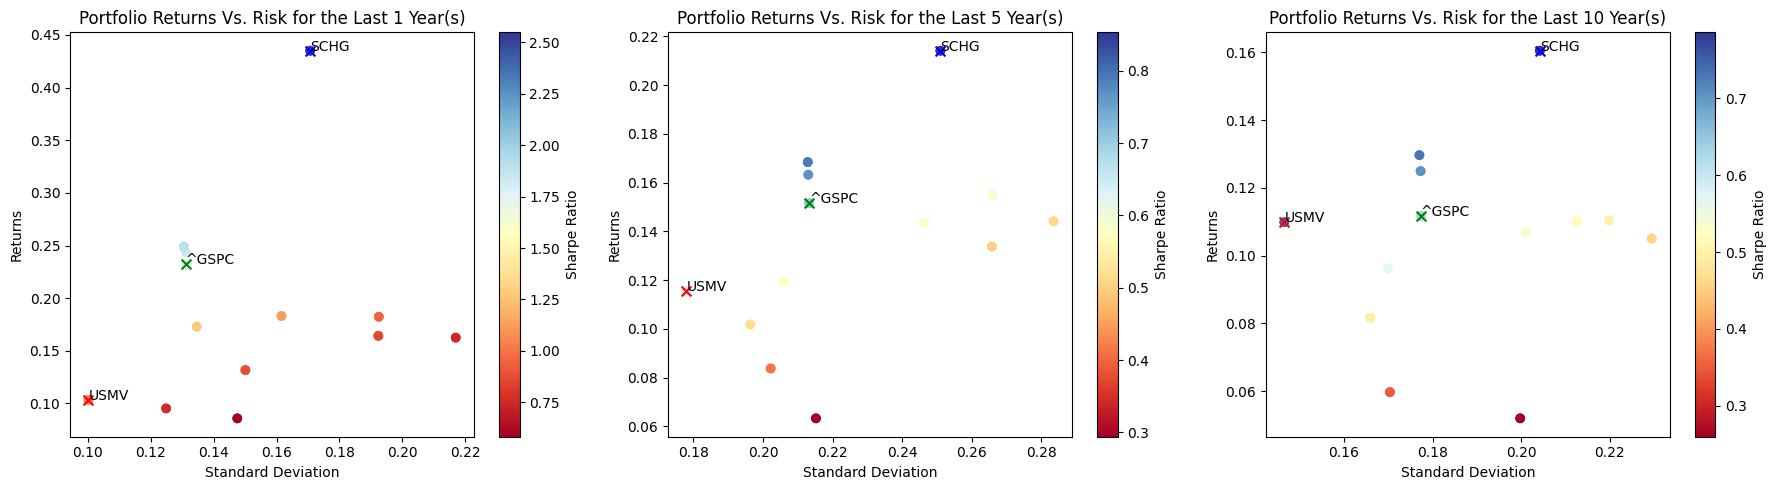

In [77]:
# Set up the figure and axes for a 1x3 grid
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot the Risk vs Returns plots for all periods in separate subplots
for i, period in enumerate(periods):
    ax = axes[i]
    plot_risk_return(period, ax=ax)  # Assuming plot_risk_return accepts an axis argument

plt.tight_layout()
plt.show()

### Plot the returns, volatility and sharpe for all securities by period

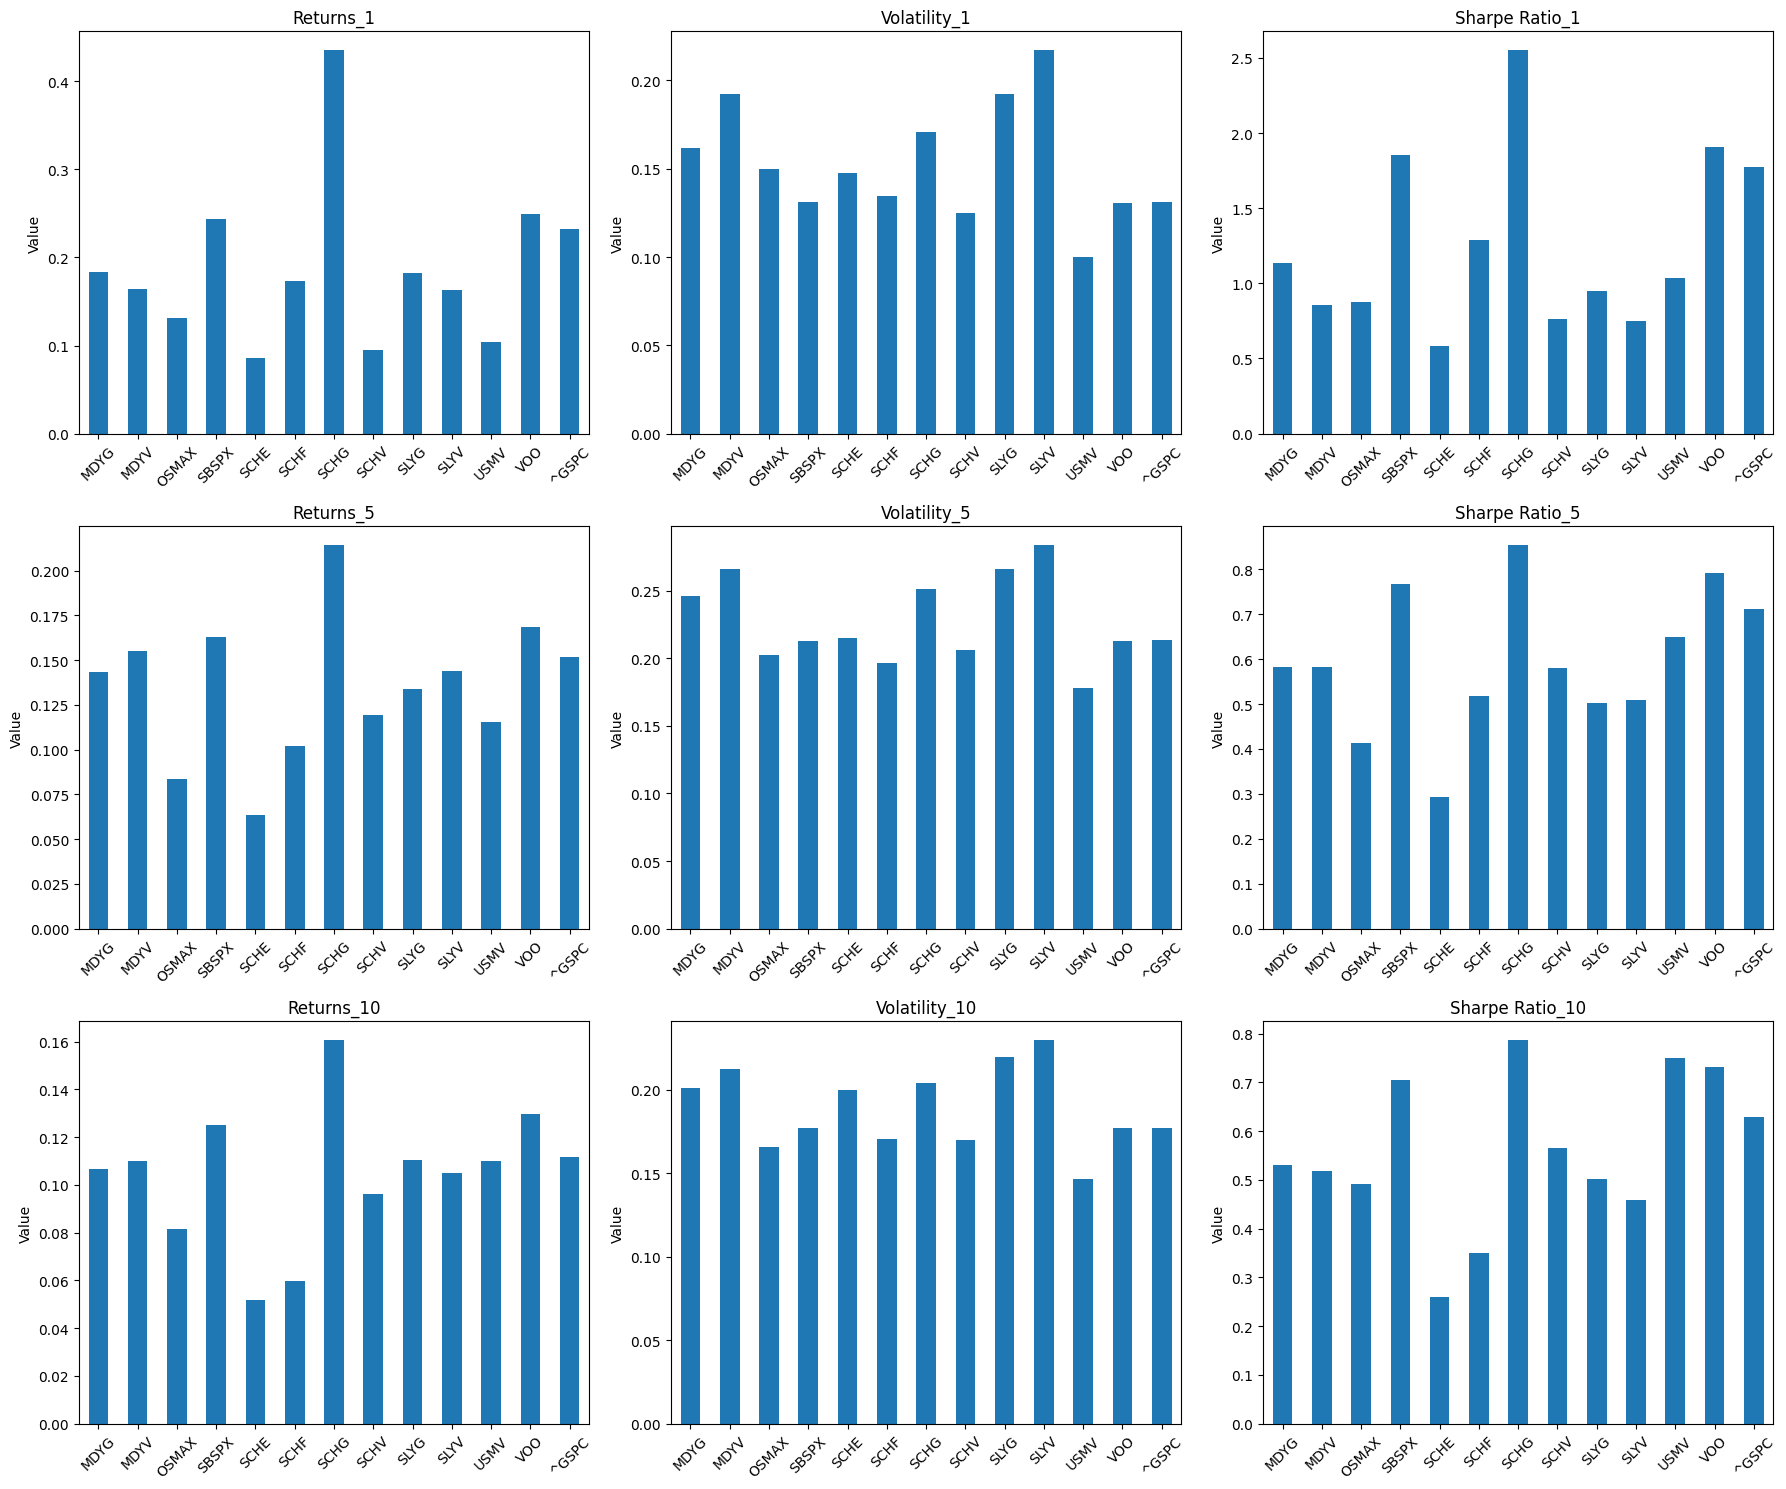

In [78]:
# Set up the figure and axes for a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Iterate over each column in simulations_df and create a bar plot in each subplot
for i, column in enumerate(simulations_df.columns):
    ax = axes_flat[i]
    simulations_df[column].plot(kind='bar', ax=ax)
    ax.set_title(column)
    ax.set_ylabel('Value')
    ax.tick_params(axis='x', labelrotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

## Calculate Portfolio Expected Value
This code is from [Sigma Coding](https://www.youtube.com/c/SigmaCoding).
https://github.com/areed1192/portfolio-optimization.git

In [79]:
# Define portfolio only with ETFs
symbols = df.columns[:-2] # Drop the S&P 500 Index
price_data_frame = df[symbols]

# of symbols we have, so let's save some time and just calculate that now.
number_of_symbols = len(symbols)
print(f'The portfolio has {number_of_symbols} ETFs to select from.')



The portfolio has 11 ETFs to select from.


In [80]:
# Calculate the Log of returns.
#log_return = np.log(1 + price_data_frame.pct_change())
log_return = period_pct_change(price_data_frame, period=5) # Test without log


# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))

# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
    random_weights  rebalance_weights
0         0.854914           0.127868
1         0.695008           0.103951
2         0.709565           0.106129
3         0.343258           0.051341
4         0.550235           0.082298
5         0.435908           0.065198
6         0.697903           0.104384
7         0.948254           0.141829
8         0.941864           0.140873
9         0.071440           0.010685
10        0.437548           0.065443
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  \
0                    0.122374                       0.212641   

   Portfolio Sharpe Ratio  
0                0.575494  
----------------------------------------------------------------------------

## Portfolio Optimization

### Monte Carlo

#### Define function to run Monte Carlo simuations for the specified period.

In [95]:
def monte_carlo(period=1, num_of_portfolios=5000):
    """
    Run Monte Carlo portfolio simulation to identify the max Sharpe ratio and the Min Volatility scenarios for the specified period.     
    Parameters:
    - period (int): Number of calendar years to extract. For example, if period is 5 and today is 3/20/2024 then the start_date us 1/1/2019 and end_date is 12/31/2023. 
    - num_of_portfolios (int): The number of simulations to run. Default is 5000.
    
    Returns:
    2 Dataframes, max_sharpe_ratio and min_volatility containing the period, annualized return, volatility, Sharpe ratio and the weights for each security.
    """   

    
    # Initialize the components, to run a Monte Carlo Simulation.

    # Get the log_return by calling the period_pct_change function
    log_return = period_pct_change(price_data_frame, period)

    # Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
    all_weights = np.zeros((num_of_portfolios, number_of_symbols))

    # Prep an array to store the returns as they are generated, 5000 possible return values.
    ret_arr = np.zeros(num_of_portfolios)

    # Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
    vol_arr = np.zeros(num_of_portfolios)

    # Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
    sharpe_arr = np.zeros(num_of_portfolios)

    # Start the simulations.
    for ind in range(num_of_portfolios):

        # First, calculate the weights.
        weights = np.array(np.random.random(number_of_symbols))
        weights = weights / np.sum(weights)

        # Add the weights, to the `weights_arrays`.
        all_weights[ind, :] = weights

        # Calculate the expected log returns, and add them to the `returns_array`.
        ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

        # Calculate the volatility, and add them to the `volatility_array`.
        vol_arr[ind] = np.sqrt(
            np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
        )

        # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
        sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

    # Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio
    simulations_data = [np.full(num_of_portfolios, period), ret_arr, vol_arr, sharpe_arr, all_weights]

    # Create a DataFrame from it, then Transpose it so it looks like our original one.
    simulations_df = pd.DataFrame(data=simulations_data).T

    # Give the columns the Proper Names.
    simulations_df.columns = [
        'Period',
        'Returns',
        'Volatility',
        'Sharpe Ratio',
        'Portfolio Weights'
    ]
    

    # Make sure the data types are correct, we don't want our floats to be strings.
    simulations_df = simulations_df.infer_objects()

    # Return the Max Sharpe Ratio from the run.
    max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

    # Return the Min Volatility from the run.
    min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]
    
    # This is so I can see the plot inside of my Jupyter Notebook.
    %matplotlib inline

    # Plot the data on a Scatter plot.
    plt.scatter(
        y=simulations_df['Returns'],
        x=simulations_df['Volatility'],
        c=simulations_df['Sharpe Ratio'],
        cmap='RdYlBu'
    )

    # Give the Plot some labels, and titles.
    plt.title(f'{period} Years Portfolio Returns Vs. Risk for {num_of_portfolios} scenarios')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Returns')

    # Plot the Max Sharpe Ratio, using a `Blue Star`.
    plt.scatter(
        max_sharpe_ratio['Volatility'],
        max_sharpe_ratio['Returns'],
        marker=(5, 1, 0),
        color='b',
        s=50
    )

    # Plot the Min Volatility, using a `Red Star`.
    plt.scatter(
        min_volatility['Volatility'],
        min_volatility['Returns'],
        marker=(5, 1, 0),
        color='r',
        s=50
    )

    # Finally, show the plot.
    plt.show()
    
    return max_sharpe_ratio, min_volatility

#### Call Monte Carlo for each period

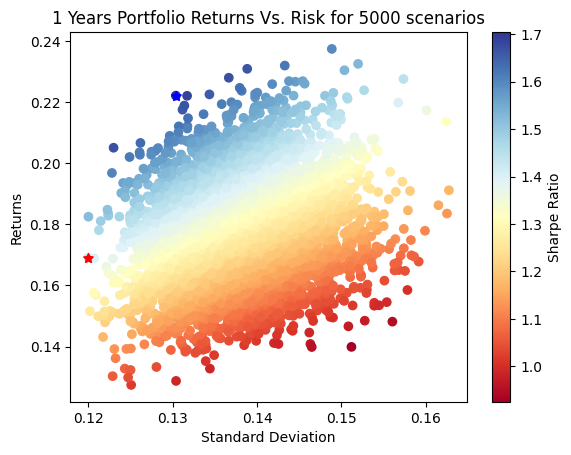

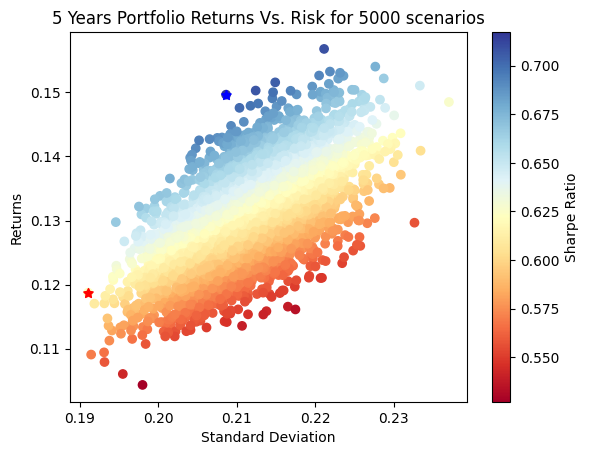

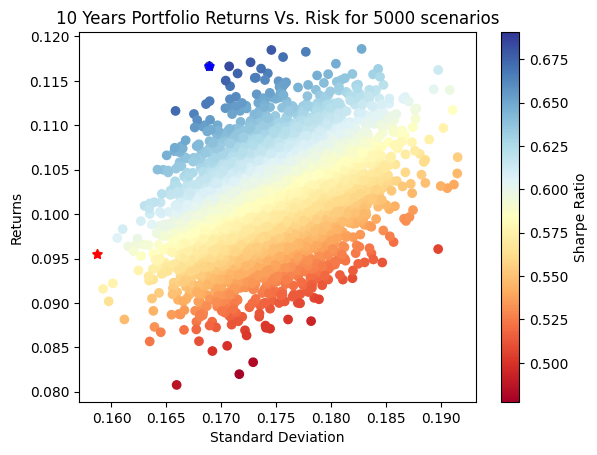


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Period                                                               1
Returns                                                       0.222199
Volatility                                                    0.130362
Sharpe Ratio                                                  1.704484
Portfolio Weights    [0.0976253178422319, 0.14076824103124508, 0.08...
Period                                                               5
Returns                                                       0.149649
Volatility                                                    0.208634
Sharpe Ratio                                                  0.717279
Portfolio Weights    [0.018997276049114525, 0.1659926390376711, 0.0...
Period                                                              10
Returns                                                       0.116648
Volatility                                      

In [96]:
# Init the dataframe to collect the result
max_sharpe_ratio = pd.DataFrame()
min_volatility = pd.DataFrame()

# Create a loop to call the function to extract
for period in periods:
    if max_sharpe_ratio.empty: # Assume that both datasets are empty
        max_sharpe_ratio, min_volatility = monte_carlo(period=period, num_of_portfolios=5000)
    else:
        max_sharpe_ratio_temp, min_volatility_temp = monte_carlo(period=period, num_of_portfolios=5000)
        max_sharpe_ratio = pd.concat([max_sharpe_ratio, max_sharpe_ratio_temp])
        min_volatility = pd.concat([min_volatility, min_volatility_temp])
    
    
# Show the combined dataframe
print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)

### Scipy Optimization

In [84]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[2] * -1

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

In [85]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.8531780359791872
       x: [ 0.000e+00  8.339e-17  0.000e+00  1.000e+00  0.000e+00
            0.000e+00  6.423e-17  0.000e+00  3.218e-17  6.131e-17
            3.608e-16]
     nit: 6
     jac: [ 2.901e-01  1.351e-01  8.932e-02 -0.000e+00  1.556e-01
            4.511e-02  1.933e-01  7.481e-02  2.112e-01  4.846e-02
            3.891e-02]
    nfev: 72
    njev: 6
--------------------------------------------------------------------------------


In [86]:
# Grab the metrics.
optimized_max_sharpe_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_max_sharpe_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.00000000e+00 8.33946708e-17 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00 6.42338212e-17 0.00000000e+00
 3.21764362e-17 6.13109812e-17 3.60822483e-16]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.21412026 0.25096786 0.85317804]
--------------------------------------------------------------------------------


In [87]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_volatility = sci_opt.minimize(
    grab_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)
print('-'*80)


OPTIMIZED VOLATILITY RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.17227321697465908
       x: [ 1.413e-01  0.000e+00  0.000e+00  1.257e-16  9.568e-17
            9.801e-17  7.161e-17  0.000e+00  1.978e-01  6.609e-01
            0.000e+00]
     nit: 12
     jac: [ 1.726e-01  1.793e-01  1.923e-01  2.231e-01  2.225e-01
            2.235e-01  2.268e-01  2.201e-01  1.728e-01  1.720e-01
            2.038e-01]
    nfev: 144
    njev: 12
--------------------------------------------------------------------------------


In [88]:
# Grab the metrics.
optimized_min_volatility_metrics = get_metrics(weights=optimized_volatility.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_min_volatility_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[1.41296293e-01 0.00000000e+00 0.00000000e+00 1.25713242e-16
 9.56808417e-17 9.80118764e-17 7.16115535e-17 0.00000000e+00
 1.97822009e-01 6.60881698e-01 0.00000000e+00]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.10183538 0.17227322 0.59112716]
--------------------------------------------------------------------------------


## Evaluate Scenarios

In [89]:
# List the scenarios
scenarios = ['Monte Carlo Max Sharpe', 'Monte Carlo Min Volatility',  'Scipy Max Sharpe', 'Scipy Min Volatility']

# Combine all the scenarios into one dataframe for summary
df_portfolio_metrics_scenarios = pd.DataFrame([max_sharpe_ratio[:3].values, min_volatility[:3].values, optimized_max_sharpe_metrics, optimized_min_volatility_metrics], index=scenarios, columns=simulations_df.columns[:3]).reset_index().rename(columns={'index' : 'Scenario'})
df_portfolio_weights_scenarios = pd.DataFrame([max_sharpe_ratio[3], min_volatility[3], optimized_sharpe.x, optimized_volatility.x], columns=symbols, index=scenarios).reset_index().rename(columns={'index' : 'Scenario'})
df_portfolio_metrics_scenarios = df_portfolio_metrics_scenarios.merge(df_portfolio_weights_scenarios, on='Scenario')

# Show scenario results
df_portfolio_metrics_scenarios.round(4)

C:\Users\sean1\AppData\Local\Temp\ipykernel_21812\1545433427.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_portfolio_weights_scenarios = pd.DataFrame([max_sharpe_ratio[3], min_volatility[3], optimized_sharpe.x, optimized_volatility.x], columns=symbols, index=scenarios).reset_index().rename(columns={'index' : 'Scenario'})


,Scenario,Returns,Volatility,Sharpe Ratio,SCHE,SCHF,SCHV,SCHG,MDYG,MDYV,SLYG,SLYV,OSMAX,USMV,SBSPX
0,Monte Carlo Max Sharpe,0.1529,0.2124,0.7199,0.0166,0.0713,0.0120,0.2620,0.1683,0.0557,0.0615,0.0013,0.0185,0.2100,0.1230
1,Monte Carlo Min Volatility,0.1155,0.1924,0.6000,0.2312,0.0372,0.1821,0.0602,0.0084,0.0972,0.0192,0.0058,0.0458,0.2550,0.0581
2,Scipy Max Sharpe,0.2141,0.2510,0.8532,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,Scipy Min Volatility,0.1018,0.1723,0.5911,0.1413,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1978,0.6609,0.0000


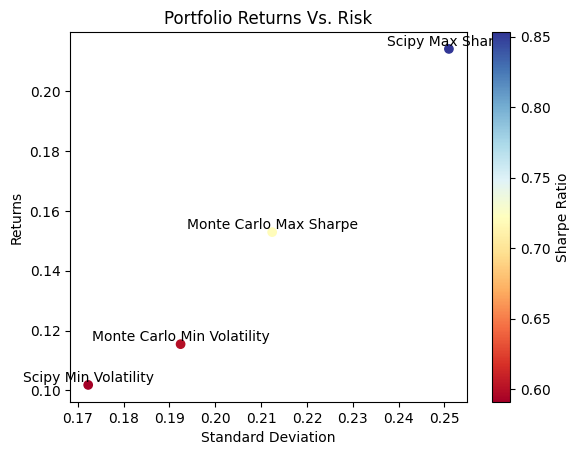

In [90]:
# Plot the Scenarios Risk and Rewards

plt.scatter(data=df_portfolio_metrics_scenarios, x='Volatility', y='Returns', c='Sharpe Ratio', cmap='RdYlBu')


for index, row in df_portfolio_metrics_scenarios.iterrows():
    plt.text(row['Volatility'], row['Returns'], row['Scenario'], va='bottom', ha='center')    

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.show()

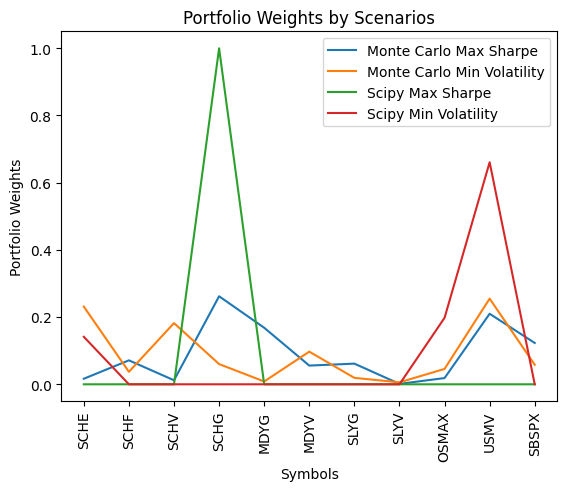

In [91]:
# Plot the Weights for each scenario

plt.plot(df_portfolio_weights_scenarios.iloc[:,1:].T)
plt.title('Portfolio Weights by Scenarios')
plt.xlabel('Symbols')
plt.ylabel('Portfolio Weights')
plt.xticks(rotation=90)
plt.legend(scenarios)
plt.show()
